# Count Active infected Cell

In this notebook, we will try to count the number of CC contributor in hexagonal grid. 

The CC contributor cells are those who contribute to cell-to-cell transmission. 

To do so, we will use a function called `get_count_cc_contributors_alltp`. 
This function takes the Morpheus log output as pd.df, the field of interest that contain the cell information, the list of cell types that are member of the cluster, the time interval of which we want to count the CC contributor cells (optional), the time step (optional), and the time symbol, as specified in the Morpheus model. The output will be a dictionary with time points as a keys, and the count of the CC contributor cells as values. 

Let try to use the function now, but before we start, let's define some required parameters. First, let's create a sample logger file in a CSV format:

In [14]:
import csv
import tempfile
import os

full_path=os.path.join(tempfile.gettempdir(), "logger.csv")

csvfile=open(full_path,'w', newline='')
obj=csv.writer(csvfile, delimiter='\t')
obj.writerow(['t', 'cell.id', 'RNA_concentration', 'infection'])
obj.writerow(['0', '1', '0.1' ,'1'])
obj.writerow(['0', '2', '0.2' ,'1'])
obj.writerow(['0', '3', '0.3' ,'0'])
obj.writerow(['0', '4', '0.4' ,'1'])
obj.writerow(['0', '5', '0.5' ,'1'])
obj.writerow(['0', '6', '0.6' ,'0'])
obj.writerow(['0', '7', '0.7' ,'0'])
obj.writerow(['0', '8', '0.8' ,'0'])
obj.writerow(['0', '9', '0.9' ,'0'])
obj.writerow(['0', '10', '0.9' ,'0'])
obj.writerow(['0', '11', '0.9' ,'0'])
obj.writerow(['0', '12', '0.9' ,'0'])
obj.writerow(['0', '13', '0.9' ,'0'])
obj.writerow(['0', '14', '0.9' ,'0'])
obj.writerow(['0', '15', '0.9' ,'0'])
obj.writerow(['0', '16', '0.9' ,'0'])
obj.writerow(['0', '17', '0.9' ,'1'])
obj.writerow(['0', '18', '0.9' ,'0'])
obj.writerow(['0', '19', '0.9' ,'1'])

obj.writerow(['1', '1', '0.1' ,'1'])
obj.writerow(['1', '2', '0.2' ,'1'])
obj.writerow(['1', '3', '0.3' ,'0'])
obj.writerow(['1', '4', '0.4' ,'1'])
obj.writerow(['1', '5', '0.5' ,'1'])
obj.writerow(['1', '6', '0.6' ,'0'])
obj.writerow(['1', '7', '0.7' ,'0'])
obj.writerow(['1', '8', '0.8' ,'1'])
obj.writerow(['1', '9', '0.9' ,'1'])
obj.writerow(['1', '10', '0.9' ,'0'])
obj.writerow(['1', '11', '0.9' ,'0'])
obj.writerow(['1', '12', '0.9' ,'0'])
obj.writerow(['1', '13', '0.9' ,'1'])
obj.writerow(['1', '14', '0.9' ,'0'])
obj.writerow(['1', '15', '0.9' ,'1'])
obj.writerow(['1', '16', '0.9' ,'1'])
obj.writerow(['1', '17', '0.9' ,'1'])
obj.writerow(['1', '18', '0.9' ,'0'])
obj.writerow(['1', '19', '0.9' ,'1'])


csvfile.close()

The data above describe a hexagonal grid with two types of cell, infected or not infected. The infected cell will have `infection` value = 1. The data describe the grid in two time steps (0 and 1).

the hexagonal grid we look like this:

Time_step=0:

               / \     / \     / \
             /     \ /     \ /     \
            | inf=1 | inf=0 | inf=1 |
            |c-id=17|c-id=18|c-id=19|
           / \     / \     / \     / \
         /     \ /     \ /     \ /     \
        | inf=0 | inf=0 | inf=0 | inf=0 |
        |c-id=13|c-id=14|c-id=15|c-id=16|
       / \     / \     / \     / \     / \
     /     \ /     \ /     \ /     \ /     \
    | inf=0 | inf=0 | inf=0 | inf=0 | inf=0 |
    |c-id=8 |c-id=9 |c-id=10|c-id=11|c-id=12|
     \     / \     / \     / \     / \     /
       \ /     \ /     \ /     \ /     \ /  
        | inf=1 | inf=1 | inf=0 | inf=0 |
        |c-id=4 |c-id=5 |c-id=6 |c-id=7 |
         \     / \     / \     / \     /
           \ /     \ /     \ /     \ /
            | inf=1 | inf=1 | inf=0 | 
            |c-id=1 |c-id=2 |c-id=3 |
             \     / \     / \     /
               \ /     \ /     \ /
               
Time_step=1:

               / \     / \     / \
             /     \ /     \ /     \
            | inf=1 | inf=0 | inf=1 |
            |c-id=17|c-id=18|c-id=19|
           / \     / \     / \     / \
         /     \ /     \ /     \ /     \
        | inf=1 | inf=0 | inf=1 | inf=1 |
        |c-id=13|c-id=14|c-id=15|c-id=16|
       / \     / \     / \     / \     / \
     /     \ /     \ /     \ /     \ /     \
    | inf=1 | inf=1 | inf=0 | inf=0 | inf=0 |
    |c-id=8 |c-id=9 |c-id=10|c-id=11|c-id=12|
     \     / \     / \     / \     / \     /
       \ /     \ /     \ /     \ /     \ /  
        | inf=1 | inf=1 | inf=0 | inf=0 |
        |c-id=4 |c-id=5 |c-id=6 |c-id=7 |
         \     / \     / \     / \     /
           \ /     \ /     \ /     \ /
            | inf=1 | inf=1 | inf=0 | 
            |c-id=1 |c-id=2 |c-id=3 |
             \     / \     / \     /
               \ /     \ /     \ /
           

where inf represents the infection and c-id represent the cell ID.

So, let's define the required parameters and run the function. The field of interest will be `infection`:

In [15]:
field_of_interest='infection'

We also need to define the list of the cell types that are members of the cluster formation. In this simple example, we consider a cell to be infected only if it has a value of 1.

In [16]:
cluster_cell_types=[1]

Finally, we will specify the `time_interval`, and the `time_symbol`, both as specified in the Morpheus model.

In [17]:
t_interval=[0,1]
t_symbol='t'

After defining all the required parameter, let's run the function. But before that, let's import the function's library. Don't forget to install the package first.

In [18]:
import fitmulticell.sumstat.hexagonal_cluster_sumstat as css

We also need to import `util` library form fitmulticell to read the CSV file as pandas df

In [19]:
import fitmulticell.util as util

No, we will read the CSV file using the `tsv_to_df` function form the external library

In [20]:
logger_file = util.tsv_to_df("/tmp")

Let's see how the logger_file loks like

In [21]:
logger_file

t  cell.id  RNA_concentration  infection
0   0        1                0.1          1
1   0        2                0.2          1
2   0        3                0.3          0
3   0        4                0.4          1
4   0        5                0.5          1
5   0        6                0.6          0
6   0        7                0.7          0
7   0        8                0.8          0
8   0        9                0.9          0
9   0       10                0.9          0
10  0       11                0.9          0
11  0       12                0.9          0
12  0       13                0.9          0
13  0       14                0.9          0
14  0       15                0.9          0
15  0       16                0.9          0
16  0       17                0.9          1
17  0       18                0.9          0
18  0       19                0.9          1
19  1        1                0.1          1
20  1        2                0.2          1
21  1        3                0.3          0
22  1        4                0.4          1
23  1        5                0.5          1
24  1        6                0.6          0
25  1        7                0.7          0
26  1        8                0.8          1
27  1        9                0.9          1
28  1       10                0.9          0
29  1       11                0.9          0
30  1       12                0.9          0
31  1       13                0.9          1
32  1       14                0.9          0
33  1       15                0.9          1
34  1       16                0.9          1
35  1       17                0.9          1
36  1       18                0.9          0
37  1       19                0.9          1

In [22]:
CC_Contributor_count_result=css.get_count_cc_contributors_alltp(logger_file, field_of_interest,cluster_cell_types,time_interval=t_interval,time_symbol=t_symbol)
print(f'the total number of cluster = {CC_Contributor_count_result}')

the total number of cluster = {0: 5, 1: 8}


As stated in the output above, at `time_point` = 0 we had 5 CC contributor cells, but at `time_point` = 1 we had 8.

We can plot the above result by using a function called `plot_active_cell_all_time_point()`.

This function will takes the dictionary output of the `get_count_cc_contributors_tp()`. But before using the function, let's import its library:

In [23]:
import fitMultiCellSumStat.plot_sumstat as pss

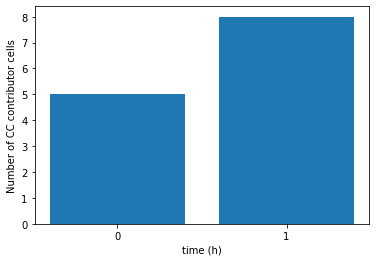

In [24]:
ax = pss.plot_active_cell_all_time_point(CC_Contributor_count_result)